## Required Packages

In [19]:
#Real Code
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 
from sklearn.preprocessing import OneHotEncoder
from numpy.linalg import norm

## Setting random seed

In [20]:
np.random.seed(0)

## Splitting and Normalising

In [21]:
(x_train,y_train),(x_val,y_val)=fashion_mnist.load_data()
x_train = x_train.astype('float')/ 255.0
x_val = x_val.astype('float')/ 255.0
print(x_train.shape, x_val.shape,y_train.shape,y_val.shape,type(x_train[0][0]),x_train[0][0])
x_train = x_train.reshape(60000,784)
x_val = x_val.reshape(10000,784)
print(x_train.shape, x_val.shape,y_train.shape,y_val.shape,type(x_train[0][0]),x_train[0][0])

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,) <class 'numpy.ndarray'> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(60000, 784) (10000, 784) (60000,) (10000,) <class 'numpy.float64'> 0.0


## 10% for testing from training data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1,stratify=y_train, random_state=0)
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,type(x_train[0][0]),x_train[0][0])

(54000, 784) (6000, 784) (54000,) (6000,) <class 'numpy.float64'> 0.0


In [23]:
print(x_train.dtype) #arr = arr.astype('float128')

float64


## One Hot Encoding

In [24]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(54000, 10) (6000, 10)


## Wandb Configuration

In [25]:
!pip install wandb --upgrade
import wandb
wandb.login()

True

## sweep configuration

In [37]:
# These are the parameters for whch the model is giving 91.6 accuracy with cross entropy loss funcion
sweep_config = {
    'method': 'grid',
    'metric' : {
    'name': 'accuracy',
    'goal': 'maximize'   
    },
    'parameters' : {
        'epochs' : {
            'values' : [10]
        },
        'batch_size' : {
            'values' : [128]
        },
        'optimizer' : {
            'values' : ['Adam']
        },
        'learing_rate' : {
            'values' : [0.0005]
        },
        'weight_initialisation' : {
            'values' : ['he']
        },
        'activation_functions' : {
            'values' : ['sigmoid']
        },
        'weight_decay' : {
            'values' : [0]
        },
        'noof_hidden' : {
            'values' : [3]
        },
        'size_of_every_hidden' : {
            'values' : [128]
        }
    }
}

In [38]:
sweep_id = wandb.sweep(sweep_config, project="DL 1.1 mse")

Create sweep with ID: bfuxqtip
Sweep URL: https://wandb.ai/026-and-009/DL%201.1%20mse/sweeps/bfuxqtip


In [39]:
#sgd gradient descent
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, noof_hidden, size_of_every_hidden, 
               init_method = 'random', activation_function = 'sigmoid'):
    hidden_sizes=[]
    for i in range(noof_hidden):
        hidden_sizes.append(size_of_every_hidden)
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.activation_function = activation_function

    self.W = {}
    self.B = {}
    np.random.seed(0)

    if init_method == "random":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])
    elif init_method == "xavier":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(1/self.sizes[i])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])
    elif init_method == "he":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(2/self.sizes[i])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])

  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.forward_activation(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)*self.H[L]*(1-self.H[L])
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_activation(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, algo= "GD", learning_rate=0.01, display_loss=True,
          mini_batch_size=60000, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9,lambda_val=0.5,l2_norm=True):
      
    if display_loss:
      loss = {}
    V_W = {}
    V_B = {}
    M_W = {}
    M_B = {}
    num_updates = 0
    for i in range(self.nh+1):
      V_W[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      V_B[i+1] = np.zeros((1, self.sizes[i+1]))
      M_W[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      M_B[i+1] = np.zeros((1, self.sizes[i+1]))
    if algo == 'SGD':
        for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
          dW = {}
          dB = {}
          points_seen = 0
          for i in range(self.nh+1):
            dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
            dB[i+1] = np.zeros((1, self.sizes[i+1]))
          for x, y in zip(X, Y):
            self.grad(x, y)
            for i in range(self.nh+1):
              dW[i+1] += self.dW[i+1]
              dB[i+1] += self.dB[i+1]
            points_seen += 1
            if points_seen % mini_batch_size == 0:
              m = X.shape[1]
              for i in range(self.nh+1):
                if l2_norm:
                  self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + learning_rate * (dW[i+1]/m)
                else:
                  self.W[i+1] -= learning_rate * (dW[i+1]/m)
                self.B[i+1] -= learning_rate * (dB[i+1]/m)
                dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
                dB[i+1] = np.zeros((1, self.sizes[i+1]))
            
          if display_loss:
            Y_pred = self.predict(X) 
            loss[epoch] = mean_squared_error(Y_pred,Y)
          Y_pred_train = self.predict(x_train)
          train_loss = mean_squared_error(Y_pred_train,y_OH_train)
          Y_pred_train = np.argmax(Y_pred_train,1)

          Y_pred_val = self.predict(x_test)
          test_loss = mean_squared_error(Y_pred_val,y_OH_val)
          Y_pred_val = np.argmax(Y_pred_val,1)


          accuracy_train = accuracy_score(Y_pred_train, y_train)
          accuracy_val = accuracy_score(Y_pred_val, y_test)
          #print(accuracy_train,accuracy_val)
          wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})
    
    
    if algo == 'Momentum':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        dW = {}
        dB = {}
        points_seen = 0
        for i in range(self.nh+1):
          dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1] = np.zeros((1, self.sizes[i+1]))
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            m = X.shape[1]
            for i in range(self.nh+1):
              V_W[i+1] = gamma * V_W[i+1] + learning_rate * (dW[i+1]/m)
              V_B[i+1] = gamma * V_B[i+1] + learning_rate * (dB[i+1]/m)
                    
            m = X.shape[1]
            for i in range(self.nh+1):
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + V_W[i+1]
              else:
                self.W[i+1] -= V_W[i+1]
              self.B[i+1] -= V_B[i+1]
              dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
              dB[i+1] = np.zeros((1, self.sizes[i+1]))
            
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = mean_squared_error(Y_pred,Y)
        Y_pred_train = self.predict(x_train)
        train_loss = mean_squared_error(Y_pred_train,y_OH_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = mean_squared_error(Y_pred_val,y_OH_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})

    if algo == 'NAG':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        dW = {}
        dB = {}
        points_seen = 0
        for i in range(self.nh+1):
          dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1] = np.zeros((1, self.sizes[i+1]))
        m = X.shape[1]
        for i in range(self.nh+1):
          self.W[i+1] -= gamma*V_W[i+1]
          self.B[i+1] -= gamma*V_B[i+1]
      
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            m = X.shape[1]
            for i in range(self.nh+1):
              self.W[i+1] -= learning_rate * (dW[i+1]/m)
              self.B[i+1] -= learning_rate * (dB[i+1]/m)
            m = X.shape[1]
            for i in range(self.nh+1):
              V_W[i+1] = gamma*V_W[i+1] + learning_rate * (dW[i+1]/m)
              V_B[i+1] = gamma*V_B[i+1] + learning_rate * (dB[i+1]/m)
            m = X.shape[1]
            for i in range(self.nh+1):
              dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
              dB[i+1] = np.zeros((1, self.sizes[i+1]))
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + gamma*V_W[i+1]
              else:
                self.W[i+1] -= gamma*V_W[i+1]
              self.B[i+1] -= gamma*V_B[i+1]
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = mean_squared_error(Y_pred,Y)
        Y_pred_train = self.predict(x_train)
        train_loss = mean_squared_error(Y_pred_train,y_OH_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = mean_squared_error(Y_pred_val,y_OH_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})

    if algo == 'RMSProp':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        dW = {}
        dB = {}
        points_seen = 0
        for i in range(self.nh+1):
          dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            m = X.shape[1]
            for i in range(self.nh+1):
              V_W[i+1] = beta*V_W[i+1] + (1-beta) * ((dW[i+1]/m)**2)
              V_B[i+1] = beta*V_B[i+1] + (1-beta) * ((dB[i+1]/m)**2)
            m = X.shape[1]
            for i in range(self.nh+1):
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W[i+1]+ eps))* (dW[i+1]/m)
              else:
                self.W[i+1] -= (learning_rate / np.sqrt(V_W[i+1]+ eps))* (dW[i+1]/m)
              self.B[i+1] -= (learning_rate / np.sqrt(V_B[i+1]+ eps))* (dB[i+1]/m)
              dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
              dB[i+1] = np.zeros((1, self.sizes[i+1]))
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = mean_squared_error(Y_pred,Y)
        Y_pred_train = self.predict(x_train)
        train_loss = mean_squared_error(Y_pred_train,y_OH_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = mean_squared_error(Y_pred_val,y_OH_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})

    if algo == 'Adam':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        dW = {}
        dB = {}
        points_seen = 0
        for i in range(self.nh+1):
          dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            m = X.shape[1]
            num_updates += 1
            for i in range(self.nh+1):
              M_W[i+1] = beta1*M_W[i+1] + (1-beta1) * (dW[i+1]/m)
              M_B[i+1] = beta1*M_B[i+1] + (1-beta1) * (dB[i+1]/m)
              V_W[i+1] = beta2*V_W[i+1] + (1-beta2) * ((dW[i+1]/m)**2)
              V_B[i+1] = beta2*V_B[i+1] + (1-beta2) * ((dB[i+1]/m)**2)
              M_W_C = M_W[i+1] / (1 - np.power(beta1, num_updates))
              M_B_C = M_B[i+1] / (1 - np.power(beta1, num_updates))
              V_W_C = V_W[i+1] / (1 - np.power(beta2, num_updates))
              V_B_C = V_B[i+1] / (1 - np.power(beta2, num_updates))
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W_C + eps))* M_W_C
              else:
                self.W[i+1] -= (learning_rate / np.sqrt(V_W_C + eps))* M_W_C
              self.B[i+1] -= (learning_rate / np.sqrt(V_B_C + eps)) * M_B_C
              dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
              dB[i+1] = np.zeros((1, self.sizes[i+1]))
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = mean_squared_error(Y_pred,Y)
        Y_pred_train = self.predict(x_train)
        train_loss = mean_squared_error(Y_pred_train,y_OH_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = mean_squared_error(Y_pred_val,y_OH_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})
    if algo == 'Nadam':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        dW = {}
        dB = {}
        points_seen = 0
        for i in range(self.nh+1):
          dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            m = X.shape[1]
            num_updates += 1
            for i in range(self.nh+1):
              M_W[i+1] = beta1*M_W[i+1] + (1-beta1) * (dW[i+1]/m)
              M_B[i+1] = beta1*M_B[i+1] + (1-beta1) * (dB[i+1]/m)
              V_W[i+1] = beta2*V_W[i+1] + (1-beta2) * ((dW[i+1]/m)**2)
              V_B[i+1] = beta2*V_B[i+1] + (1-beta2) * ((dB[i+1]/m)**2)
              M_W_C = M_W[i+1] / (1 - np.power(beta1, num_updates))
              M_B_C = M_B[i+1] / (1 - np.power(beta1, num_updates))
              V_W_C = V_W[i+1] / (1 - np.power(beta2, num_updates))
              V_B_C = V_B[i+1] / (1 - np.power(beta2, num_updates))
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W_C + eps))* (beta1*M_W_C + (1-beta1)/(1-np.power(beta1,num_updates))* (dW[i+1]/m))
              else:
                self.W[i+1] -= (learning_rate / np.sqrt(V_W_C + eps))* (beta1*M_W_C + (1-beta1)/(1-np.power(beta1,num_updates))* (dW[i+1]/m) )
              self.B[i+1] -= (learning_rate / np.sqrt(V_B_C + eps)) * (beta1*M_B_C + (1-beta1)/(1-np.power(beta1,num_updates))* (dB[i+1]/m))
              dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
              dB[i+1] = np.zeros((1, self.sizes[i+1]))
       
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = mean_squared_error(Y_pred,Y)
        Y_pred_train = self.predict(x_train)
        train_loss = mean_squared_error(Y_pred_train,y_OH_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = mean_squared_error(Y_pred_val,y_OH_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})
    
    if display_loss:
        plt.plot(np.array(list(loss.values())).astype(float))
        plt.xlabel('Epochs')
        plt.ylabel('CE')
        plt.show()
    print(accuracy_train,accuracy_val)

In [40]:
#code
def train():
    config_defaluts = {
        'epochs' :5,
        'learing_rate' : 1e-3,
        'batch_size' : 64,
        'optimizer' : 'RMSProp',
        'weight_initialisation' : 'random',
        'activation_functions' : 'sigmoid',
        'weight_decay' : 0.0005,
        'noof_hidden' : 2,
        'size_of_every_hidden' : 10

    }
    wandb.init(config=config_defaluts)
    config=wandb.config
    wandb.init(name="hl_"+str(config.noof_hidden)+"_bs_"+str(config.batch_size)+"_ac_"+str(config.activation_functions)+"_MSE_")
    ffsn_multi = FFSN_MultiClass(784,10,config.noof_hidden,config.size_of_every_hidden,init_method=config.weight_initialisation, 
                                 activation_function=config.activation_functions)
    ffsn_multi.fit(x_train,y_OH_train,epochs=config.epochs,learning_rate=config.learing_rate,
                   algo= config.optimizer,mini_batch_size=config.batch_size,lambda_val=config.weight_decay)

wandb: Agent Starting Run: o5l40koq with config:
wandb: 	activation_functions: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learing_rate: 0.0005
wandb: 	noof_hidden: 3
wandb: 	optimizer: Adam
wandb: 	size_of_every_hidden: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: he


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:310: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?epoch/s]

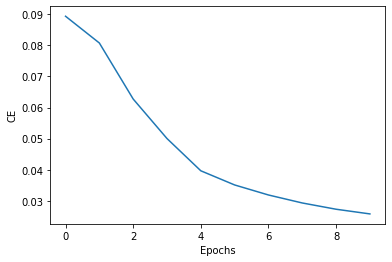

0.8272407407407407 0.823


accuracy,▁▃▆▇▇▇████
epochs,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
val_accuracy,▁▃▆▇▇▇████
val_loss,█▇▅▄▂▂▂▁▁▁
accuracy,0.82724
epochs,10
loss,0.02578
val_accuracy,0.823
val_loss,0.02639


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [41]:
wandb.agent(sweep_id, train)

In [ ]:
#ffsn_multi = FFSN_MultiClass(784,10,2,32,init_method='xavier', activation_function='sigmoid')
#ffsn_multi.fit(x_train,y_OH_train,epochs=10,learning_rate=0.001,algo= "RMSProp",mini_batch_size=256)

In [ ]:
'''
reasons :
increasing learning rate will lead to fluctuations in the epochs vs loss curve
'''